In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [2]:
# Constants
F = 0.096485  # Faraday constant : pC/amol
R = 0.008314  # gas constant : fJ/amol/K
T = 310       # temperature : K
Cm = 1e-5     # membrane capacitance : nF/µm²
z = np.array([1, 1, -1])  # valence : K+ Na+ Cl-
N_A = 6.022e5 # Avogadro's number /10^18 (attomoles)

In [3]:
# Areas (µm²)
A_P = 293103
A_F = 200 * 100
A_I = 280 * 0.020
A_M = 280 * 5
A_E = 55071
A_H = 271
A_N = 400 * 20
dim_area = np.array([A_P, A_F, A_I, A_M, A_E, A_H, A_N])

In [4]:
# Lengths (µm)
l_PF = 15 * 220
l_FI = 25500
l_IM = 25500
l_ME = 280
l_EH = 64
l_HP = 1280
l_EN = 400
l_NP = 400 * 4
l_PI = 280
l_IE = 280
l_EP = 2000
dim_length = np.array([l_PF, l_FI, l_IM, l_ME, l_EH, l_HP, l_EN, l_NP, l_PI, l_IE, l_EP])

In [5]:
# Connectivity matrix (7 x 11)
K = np.array([
    [-1,  0,  0,  0,  0,  1,  0,  1, -1,  0,  1],
    [ 1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  1, -1,  0,  0,  0,  0,  0,  1, -1,  0],
    [ 0,  0,  1, -1,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  1, -1,  0, -1,  0,  0,  1, -1],
    [ 0,  0,  0,  0,  1, -1,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  1, -1,  0,  0,  0]
])

In [6]:
Ka = K[0:6,:]

In [7]:
# Loop matrix (5 x 11)
L = np.array([
    [ 1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  1,  1, -1, -1,  0,  0,  0],
    [ 1,  1,  0,  0,  0,  0,  0,  0, -1,  0,  0],
    [ 0,  0,  1,  1,  0,  0,  0,  0,  0, -1,  0],
    [ 0,  0,  0,  0,  1,  1,  0,  0,  0,  0, -1]
])

In [8]:
# Initial Conditions
# Voltages (mV)
v0 = np.array([5, -90, -5, 5, 150, -65, 85, 1, -85, 0, 85])
Nv = len(v0)

# K+ concentrations (mM)
ck0 = np.array([4, 150, 3, 149, 150, 140, 150])

# Na+ concentrations (mM)
cna0 = np.array([140, 5, 100, 5, 5, 5, 5])

# Cl- concentration
cl_0 = 120

# Intrastrial space volume
w0 = dim_area[2]

# All initial conditions
x0 = np.concatenate([v0, ck0, cna0, [w0]])

# Parameters
p = np.ones(24)
tspan = [1e-6, 1e8]

In [9]:
def f(t, x, p):
# Extract state variables
    Nv = 11
    v = x[:Nv]              # Voltages
    ck = x[Nv:Nv+7]         # Potassium concentrations
    cna = x[Nv+7:Nv+14]     # Sodium concentrations
    w = x[-1]               # Intrastrial space volume
    
    # Initialize flux matrix for 3 ions (K+, Na+, Cl-) and 11 pathways
    flux = np.zeros((3, 11))
    
    # Parameters
    P_MET = p[0] * 0.2 * 0.229  # Permeability # NOTE: I REMOVED TIME PART SINCE STIM = 0
    v_pump = 150
    
    # Sensitivities and ATP-dependent voltages
    S_pump_MI = 4500
    S_pump_FP = 4500
    S_pump_HP = 100
    S_pump_NP = 1
    v_ATP_M = 622
    v_ATP_F = 622
    v_ATP_H = 450
    v_ATP_N = 300
    
    # Permeabilities
    P_Na_ME = 0.1 * 0.1678
    P_Na_HP = 0.00001
    P_Na_EN = 0.001
    P_Na_NP = 0.0001
    P_Na_EP = 0.0001

    P_Kir51 = 0.15
    Po_Kir51 = 1 / (1 + np.exp((-v[0] + 30) / 20))
    P_Kir41 = 0.1
    Po_Kir41 = 1 / (1 + np.exp((v[1] + 46.8) / 29.3))
    P_Kv = 0.01
    Po_Kv = 1 / (1 + np.exp(-(v[1] + 42.6) / 17.5))
    P_sK = 0
    Po_sK = 1 / (1 + np.exp(-(v[3] + 20)) / 23)
    Po_K_HP = 1 / (1 + np.exp(-(v[5] + 50) / 15))
    P_K_HP = 0.175 * Po_K_HP
    P_K_EN = 0.0001
    P_K_NP = 0.001
    P_K_EP = 0.0001

    P_Cl_PF = 0.03845
    P_Cl_IM = 0.03845
    
    v_mc_pump = (S_pump_MI * p[1] / N_A * v_pump *
        np.tanh((F / (R * T) / 2) *
        (-v[2] + 2 * (R * T / F) * np.log(ck[2] / ck[3]) -
        3 * (R * T / F) * np.log(cna[2] / cna[3]) +
        v_ATP_M * p[5]))) 

    v_f_pump = S_pump_FP * p[2] / N_A * v_pump * np.tanh((F / (R * T)) / 2 * 
        (-v[0] + 2 * (R * T / F) * np.log(ck[0] / ck[1]) - 3 * (R * T / F) * 
        np.log(cna[0] / cna[1]) + v_ATP_F * p[6]));

    v_f_nkcc = -3 * v_f_pump;

    # v_h_pump calculation
    v_h_pump = (S_pump_HP * p[3] / N_A * v_pump *
                np.tanh((F / (R * T) / 2) *
                (v[5] + 2 * (R * T / F) * np.log(ck[0] / ck[5]) -
                3 * (R * T / F) * np.log(cna[0] / cna[5]) +
                v_ATP_H * p[7])))

    # v_n_pump calculation
    v_n_pump = (S_pump_NP * p[4] / N_A * v_pump *
                np.tanh((F / (R * T) / 2) *
                (v[7] + 2 * (R * T / F) * np.log(ck[0] / ck[6]) -
                3 * (R * T / F) * np.log(cna[0] / cna[6]) +
                v_ATP_N * p[8])))

    # Calculate Na+ fluxes
    flux[0,8] = jghk(v[8], cna[0], cna[2], 0, z[0]);
    flux[0,9] = jghk(v[9], cna[2], cna[4], 0, z[0]);
    v_mc_nkcc = -3 * v_mc_pump + flux[0,8] - flux[0,9];
    flux[0,0] = jghk(v[0], cna[0], cna[1], 0, z[0]) - 3 * v_f_pump - v_f_nkcc;
    flux[0,1] = jghk(v[1], cna[1], cna[2], 0, z[0]);
    flux[0,2] = -3 * v_mc_pump - v_mc_nkcc;
    flux[0,3] = jghk(v[3], cna[3], cna[4], P_Na_ME * p[9], z[0]);
    flux[0,4] = jghk(v[4], cna[4], cna[5], P_MET * 0.9, 1);
    flux[0,5] = 3 * v_h_pump + jghk(v[5], cna[5], cna[0], P_Na_HP * p[10], z[0]);
    flux[0,6] = jghk(v[6], cna[4], cna[6], P_Na_EN * p[11], z[0]);
    flux[0,7] = 3 * v_n_pump + jghk(v[7], cna[6], cna[0], P_Na_NP * p[12], z[0]);
    flux[0,10] = jghk(v[10], cna[4], cna[0], P_Na_EP * p[13], z[0]);
    
    # Calculate K+ fluxes
    flux[1,0] = jghk(v[0], ck[0], ck[1], P_Kir51 * Po_Kir51 * p[14], z[1]) + 2 * v_f_pump - v_f_nkcc;
    flux[1,1] = jghk(v[1], ck[1], ck[2], P_Kir41 * Po_Kir41 * p[15] + P_Kv * Po_Kv * p[16], z[1]);
    flux[1,2] = jghk(v[2], ck[2], ck[3], 0, z[1]) + 2 * v_mc_pump - v_mc_nkcc;
    flux[1,3] = jghk(v[3], ck[3], ck[4], P_sK * Po_sK * p[17], z[1]);
    flux[1,4] = jghk(v[4], ck[4], ck[5], P_MET, z[1]);
    flux[1,5] = -2 * v_h_pump + jghk(v[5], ck[5], ck[0], P_K_HP * p[18] * Po_K_HP, z[1]);
    flux[1,6] = jghk(v[6], ck[4], ck[6], P_K_EN * p[19], z[1]);
    flux[1,7] = -2 * v_n_pump + jghk(v[7], ck[6], ck[0], P_K_NP * p[20], z[1]);
    flux[1,8] = jghk(v[8], ck[0], ck[2], 0, z[1]);
    flux[1,9] = jghk(v[9], ck[2], ck[4], 0, z[1]);
    flux[1,10] = jghk(v[10], ck[4], ck[0], P_K_EP * p[21], z[1]);
    
    # Calculate Cl- fluxes
    flux[2,0] = jghk(v[0], 140, 120, 10 * P_Cl_PF * p[22], z[2]) - 2 * v_f_nkcc;
    flux[2,2] = jghk(v[2], 140, cl_0, P_Cl_IM * p[23], z[2]);
    flux[2,8] = jghk(v[8], 140, 140, 0, z[2]);
    flux[2,9] = jghk(v[9], 140, 140, 0, z[2]);
    flux[2,10] = jghk(v[10], 140, 140, 0, z[2]);

    I_Na = (flux[0, :] * z[0] * F * dim_length);
    I_K = (flux[1, :] * z[1] * F * dim_length);
    I_Cl = (flux[2, :] * z[2] * F * dim_length);
    I = I_Na + I_K + I_Cl;

    fv = np.concatenate((-Ka @ I, np.dot(L, v)))
    fk = K @ I_K;
    fna = K @ I_Na;
    fw = 310 - ck[2] - cna[2] - cl_0 - 10 * w0 / w

    return np.hstack((fv, fk, fna, fw))

In [10]:
def jghk(v, c_in, c_out, P, z):
    F = 0.096485  # pC/amol
    R = 0.008314  # fJ/amol/°K
    T = 310  # °K
    beta = z * F / R / T
    
    if np.isclose(1 - np.exp(-beta * v), 0):
        j = P * (c_in - c_out)
    elif beta * v < -500:
        j = P * (beta * v - 1) * c_out
    else:
        j = P * beta * v * (c_in - c_out * np.exp(-beta * v)) / (1 - np.exp(-beta * v))
    
    return j


In [18]:
def mass(t, x, p):
    dim_area[2] = x[25]

    Mv = np.vstack( ( 
        np.round((Ka @ np.diag(dim_length * Cm)), 4), 
        np.zeros((5,11)) 
    ) )
    Mk = np.diag(dim_area * z[1] * F)  # K+ concentration equations
    Mna = np.diag(dim_area * z[0] * F)  # Na+ concentration equations
    
    M = block_diag(Mv, Mk, Mna, 0)
    
    # M = block_diag(M, 0);
    M[13, 25] = x[13] * F; # volume term in c_k ode
    M[20, 25] = x[20] * F; # volume term in c_na ode
    
    return M

M * dx/dt = f(t, x, p) $$

In [12]:
def apply_mass(t, x):
    M = mass(t, x, p)
    dxdt = f(t, x, p)
    M_inv = np.linalg.pinv(M)
    return M_inv @ dxdt

Below works though does not output same matrix as MATLAB code

In [13]:
sol = solve_ivp(apply_mass, tspan, x0, method='LSODA', t_eval=None, rtol=1e-7)

tTemp = sol.t
xTemp = sol.y.T
nT = xTemp.shape[0]
X = xTemp
tPlot = tTemp

In [14]:
pythonIonChannel = X[-1]

In [15]:
matlabIonChannel = np.array([
    7.72927234041150, -81.3922341724326, 4.11772517122855, 124.340516028024, 
    4.28083447416748, -59.0761138413986, -13.5545168828377, -41.2407624843934, 
    -73.6629618320210, 128.458241199252, -54.7952793672311, 12.4015156678516, 
    191.689840041089, 9.10558947033942, 153.484609287089, 103.274031114635, 
    121.428187059021, 59.4596907841968, 128.753960304880, 5, 167.056175369980, 
    0.492209131316432, 51.7252203771861, 23.5782796056878, 95.5399443523191, 
    4.04675880658276
])

In [16]:
X[-1] - matlabIonChannel

array([ 2.57674661e-03, -1.55046905e+02, -5.43290746e-10, -6.01304309e+01,
        1.64828027e+01,  2.48627722e+03,  1.51546017e+01,  4.47887922e+01,
       -1.27132041e+01, -6.91480399e+01, -2.74019259e+02,  1.59274235e+01,
        2.13923054e+01, -9.07507732e+00, -1.13304942e+01, -8.66619703e+01,
       -1.21421613e+02, -3.43574014e+01, -1.73877964e+01,  7.99360578e-15,
       -6.70118089e+01,  1.20151711e+01,  8.66653832e+01,  1.24159752e+02,
        3.41496801e+01,  1.55073991e+00])

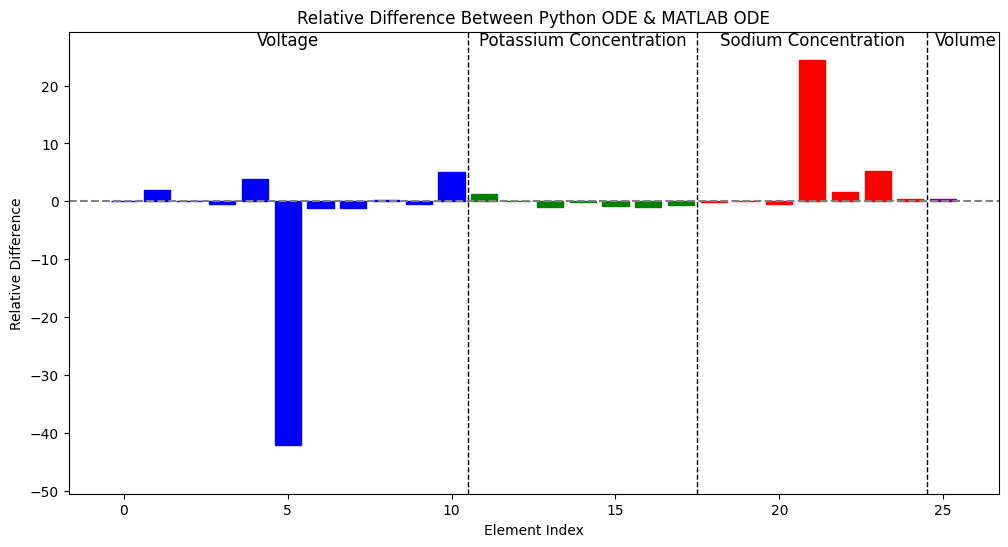

In [17]:
relative_difference = (pythonIonChannel - matlabIonChannel) / matlabIonChannel

voltage_indices = range(11)
potassium_indices = range(11, 18)
sodium_indices = range(18, 25)
volume_index = [25]

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(relative_difference)), relative_difference, color='skyblue')

for i in voltage_indices:
    bars[i].set_color('blue')
for i in potassium_indices:
    bars[i].set_color('green')
for i in sodium_indices:
    bars[i].set_color('red')
bars[volume_index[0]].set_color('purple')

plt.axvline(x=10.5, color='black', linestyle='--', lw=1)  # End of Voltage
plt.axvline(x=17.5, color='black', linestyle='--', lw=1)  # End of Potassium Concentration
plt.axvline(x=24.5, color='black', linestyle='--', lw=1)  # End of Sodium Concentration

plt.text(5, max(relative_difference) * 1.1, 'Voltage', horizontalalignment='center', fontsize=12)
plt.text(14, max(relative_difference) * 1.1, 'Potassium Concentration', horizontalalignment='center', fontsize=12)
plt.text(21, max(relative_difference) * 1.1, 'Sodium Concentration', horizontalalignment='center', fontsize=12)
plt.text(25.7, max(relative_difference) * 1.1, 'Volume', horizontalalignment='center', fontsize=12)

plt.xlabel('Element Index')
plt.ylabel('Relative Difference')
plt.title('Relative Difference Between Python ODE & MATLAB ODE')
plt.axhline(0, color='grey', linestyle='--')
plt.ylim([min(relative_difference) * 1.2, max(relative_difference) * 1.2])
plt.show()

Gives ValueError: array must not contain infs or NaNs

In [ ]:
sol = solve_ivp(
    fun=apply_mass,
    t_span=tspan,
    y0=x0,
    method='Radau',
    rtol=1e7,
)